In [1]:
import pandas as pd
import numpy as np
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import keyboard
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

2023-04-06 15:21:35.474642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0


# Preprocessing function

In [5]:
def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '\'\'', '//', '»', '|', '’', '`', '+', '$',
                     '\"\"', '</', '&', "/", '#', '\'', '*', '``', '%', '[', ']', '{', '}']

stop_words = stopwords.words('english') + ['14000kbps', '1080p', "n't", '\r\n', "'s", '4k', "'m", 'mp4', 'error', '404']
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    """
    s = s.lower()
    # Replace ips
    s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
    # Isolate punctuation
    s = re.sub(r'([.\(\)\!\?\-\\\/\,])', r' \1 ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', ' zero ')
    s = s.replace('1', ' one ')
    s = s.replace('2', ' two ')
    s = s.replace('3', ' three ')
    s = s.replace('4', ' four ')
    s = s.replace('5', ' five ')
    s = s.replace('6', ' six ')
    s = s.replace('7', ' seven ')
    s = s.replace('8', ' eight ')
    s = s.replace('9', ' nine ')
    return s

In [7]:
data[:1000].apply(lambda row: str(row.text), axis=1)

0                                       My Favorite Slut
1      girlfriends sit on each other's faces with the...
2                     bound beauty kisses her girlfriend
3      MORGAN - Anytime - Nail Painting On The Slave'...
4                      TRANSGENDER COACHING (wmv) PART 1
                             ...                        
995    Captain Next Fucks Hot Wife Laney On Her Husba...
996    Captain Next Fucks Hot Wife Laney On Her Husba...
997    Captain Next Fucks Hot Wife Laney On Her Husba...
998    XY19 - Sexy Chinese Maid Gets Femdom With Vibr...
999     The Strongest Reverse Headscissors Contest HDMP4
Length: 1000, dtype: object

In [8]:
# Dropping the rows with "Sci"
# identify partial string
# discard = ["<dev"]
  
# # drop rows that contain the partial string "dev"
# data[~data.text.str.contains('|'.join(discard))]

data = data[data['text'].str.contains('<div' or '<p' or 'p>' or '<b'or '<br>' or '&nbsp' or '=')==False]

In [9]:
data

,text,labels
0,My Favorite Slut,0
1,girlfriends sit on each other's faces with the...,0
2,bound beauty kisses her girlfriend,0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0
4,TRANSGENDER COACHING (wmv) PART 1,0
...,...,...
83594,"ebony,hotwife,wife,swinger,cuckold,bigass",0
83595,"ssbhm, bhm, ffa, female fat admire, fat admire...",0
83596,"Feet in heels, sexy shoes, high heels, high he...",0
83597,"foot fetish, breeding, kinky, fetish porn, bon...",0


In [10]:
# data[:100].apply(lambda row: bs(row['text']).get_text().replace('\n',' '),axis=1)

In [11]:
data[:100].apply(lambda row: preprocess(row.text, punctuation_marks, stop_words), axis=1) #, morph), axis=1)

0                                         favorite slut
1                           girlfriends sit faces asses
2                        bound beauty kisses girlfriend
3               morgan anytime nail painting slave face
4                       transgender coaching wmv part 1
                            ...                        
95    real mesmerized housewife brooklyn follows orders
96                     kaylia strict hogtie naked floor
97                 real mesmerized submissive housewife
98                        ehesklave muss füsse lutschen
99    uncut buck nekkid fucks creampies polly bundy ...
Length: 100, dtype: object

In [12]:
data['text_preprocessed'] = data.apply(lambda row: bs(row.text).get_text().replace('\n',' '),axis=1)
# data['text_preprocessed'] = data.apply(lambda row: HTMLParser(row.text).body.text(separator=' ').replace('\n',' '),axis=1)

In [13]:
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

In [14]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [15]:
data.head()

,text_preprocessed,labels,text
0,favorite slut,0,My Favorite Slut
1,girlfriends sit faces asses,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,TRANSGENDER COACHING (wmv) PART 1


# Tensorflow

In [16]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [17]:
counter = counter_word(data.text_preprocessed)  

In [18]:
data.text_preprocessed

0                                            favorite slut
1                              girlfriends sit faces asses
2                           bound beauty kisses girlfriend
3                  morgan anytime nail painting slave face
4                          transgender coaching wmv part 1
                               ...                        
83594            ebony hotwife wife swinger cuckold bigass
83595    ssbhm bhm ffa female fat admire fat admire fee...
83596    feet heels sexy shoes high heels high heel fet...
83597       foot fetish breeding kinky fetish porn bondage
83598    fetish content ellie boulder ellie boulder por...
Name: text_preprocessed, Length: 77496, dtype: object

In [19]:
num_unique_words = len(counter)

In [20]:
num_unique_words

68614

In [21]:
counter

Counter({'favorite': 329,
         'slut': 1972,
         'girlfriends': 170,
         'sit': 735,
         'faces': 256,
         'asses': 306,
         'bound': 1876,
         'beauty': 528,
         'kisses': 320,
         'girlfriend': 495,
         'morgan': 246,
         'anytime': 69,
         'nail': 446,
         'painting': 110,
         'slave': 6828,
         'face': 6905,
         'transgender': 122,
         'coaching': 8,
         'wmv': 1715,
         'part': 2635,
         '1': 1303,
         '2212terra-kept': 1,
         'tied': 2079,
         'gagged': 1673,
         'garage': 22,
         'cadence': 79,
         'gets': 1715,
         'catfished': 3,
         '2': 1667,
         '3': 868,
         'mobile': 276,
         'lick': 1515,
         'sexy': 6793,
         'mules': 144,
         'clean': 709,
         'shoe': 1987,
         'worship': 8152,
         'domination': 10099,
         'gorgeous': 636,
         'yet': 210,
         'hangry': 2,
         'amazonia

In [22]:
counter.most_common(150)

[('fetish', 23650),
 ('feet', 19744),
 ('foot', 18333),
 ('ass', 12853),
 ('big', 10502),
 ('domination', 10099),
 ('clip', 9009),
 ('cum', 8674),
 ('worship', 8152),
 ('bondage', 7403),
 ('store', 7216),
 ('cock', 7112),
 ('face', 6905),
 ('slave', 6828),
 ('sexy', 6793),
 ('female', 6669),
 ('femdom', 6426),
 ('pussy', 6279),
 ('girl', 5930),
 ('heels', 5745),
 ('humiliation', 5388),
 ('soles', 5380),
 ('sex', 5267),
 ('video', 5237),
 ('high', 5212),
 ('balloon', 4836),
 ('legs', 4781),
 ('mistress', 4723),
 ('blow', 4689),
 ('clips', 4663),
 ('tits', 4620),
 ('pov', 4596),
 ('girls', 4445),
 ('get', 4422),
 ('pantyhose', 4375),
 ('milf', 4366),
 ('goddess', 4288),
 ('hot', 4142),
 ('play', 4068),
 ('tickling', 4042),
 ('fucking', 4000),
 ('mouth', 3997),
 ('crush', 3967),
 ('black', 3909),
 ('like', 3897),
 ('farting', 3837),
 ('time', 3765),
 ('toes', 3757),
 ('videos', 3727),
 ('amateur', 3715),
 ('fuck', 3707),
 ('long', 3518),
 ('socks', 3451),
 ('tease', 3343),
 ('masturbation

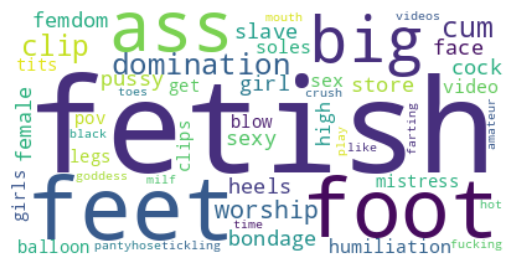

In [23]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [24]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [25]:
train.text_preprocessed.to_numpy()

array(['favorite slut', 'girlfriends sit faces asses',
       'bound beauty kisses girlfriend', ...,
       'gay stud muscle body cock dick fucking jerking jacking masturbating ripped jock worship str8 gay bisexual college guys boys gym workout cumming cum sucking suck nipples hairy pecs twink ass rimming',
       'handjos blackmail step-monther face riding tease denial baby talk bi cuckold chastity milfs brats home wrecker asian face sitting cocktease women control women top decadent women femdom fetish decadent women fucking',
       'empress maxena mistress maxena madame diva herrin lady model fetish fetish-model bizarre bdsm domina mistress prodom dominatrix topdomina goddess nylon foot fetish latex leather rubber uniform bondage slave-training caning spanking cbt whipping lifestyle humiliation strap fetish spanking ass worship bastinado bootfetis hdomina-world pie golden shower'],
      dtype=object)

In [26]:
X_train,  y_train

(array(['favorite slut', 'girlfriends sit faces asses',
        'bound beauty kisses girlfriend', ...,
        'gay stud muscle body cock dick fucking jerking jacking masturbating ripped jock worship str8 gay bisexual college guys boys gym workout cumming cum sucking suck nipples hairy pecs twink ass rimming',
        'handjos blackmail step-monther face riding tease denial baby talk bi cuckold chastity milfs brats home wrecker asian face sitting cocktease women control women top decadent women femdom fetish decadent women fucking',
        'empress maxena mistress maxena madame diva herrin lady model fetish fetish-model bizarre bdsm domina mistress prodom dominatrix topdomina goddess nylon foot fetish latex leather rubber uniform bondage slave-training caning spanking cbt whipping lifestyle humiliation strap fetish spanking ass worship bastinado bootfetis hdomina-world pie golden shower'],
       dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [27]:
X_train.shape, X_val.shape

((61996,), (15500,))

# Tokenize

In [28]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer2 = Tokenizer(num_words=num_unique_words)
tokenizer2.fit_on_texts(X_train)

In [29]:
import pickle

# saving
with open('../models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [30]:
# each word have a unique index
word_index = tokenizer.word_index
word_index

{'fetish': 1,
 'feet': 2,
 'foot': 3,
 'ass': 4,
 'big': 5,
 'domination': 6,
 'cum': 7,
 'worship': 8,
 'clip': 9,
 'bondage': 10,
 'face': 11,
 'cock': 12,
 'slave': 13,
 'sexy': 14,
 'girl': 15,
 'female': 16,
 'femdom': 17,
 'pussy': 18,
 'heels': 19,
 'soles': 20,
 'humiliation': 21,
 'store': 22,
 'high': 23,
 'video': 24,
 'sex': 25,
 'pantyhose': 26,
 'balloon': 27,
 'legs': 28,
 'pov': 29,
 'blow': 30,
 'mistress': 31,
 'tits': 32,
 'get': 33,
 'milf': 34,
 'goddess': 35,
 'mouth': 36,
 'girls': 37,
 'play': 38,
 'hot': 39,
 'fucking': 40,
 'time': 41,
 'tickling': 42,
 'like': 43,
 'farting': 44,
 'black': 45,
 'crush': 46,
 'stockings': 47,
 'fuck': 48,
 'toes': 49,
 'clips': 50,
 'long': 51,
 'hd': 52,
 'socks': 53,
 'amateur': 54,
 'tease': 55,
 'hard': 56,
 'smoking': 57,
 'one': 58,
 'dirty': 59,
 'masturbation': 60,
 'full': 61,
 'training': 62,
 'videos': 63,
 'spanking': 64,
 'little': 65,
 'see': 66,
 'crushing': 67,
 'wrestling': 68,
 'part': 69,
 'woman': 70,
 'wan

In [31]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [32]:
print(X_train[1])
print(X_train_sequences[1])

girlfriends sit faces asses
[1712, 385, 1125, 937]


In [33]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape


((61996, 20), (15500, 20))

In [34]:
X_train_padded[10]

array([1141, 3121,  172,   14, 1834,  391,  116,    8,    6,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [35]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

morgan anytime lick sexy mules clean shoe worship domination
[1141, 3121, 172, 14, 1834, 391, 116, 8, 6]
[1141 3121  172   14 1834  391  116    8    6    0    0    0    0    0
    0    0    0    0    0    0]


In [36]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [37]:
reverse_word_index

{1: 'fetish',
 2: 'feet',
 3: 'foot',
 4: 'ass',
 5: 'big',
 6: 'domination',
 7: 'cum',
 8: 'worship',
 9: 'clip',
 10: 'bondage',
 11: 'face',
 12: 'cock',
 13: 'slave',
 14: 'sexy',
 15: 'girl',
 16: 'female',
 17: 'femdom',
 18: 'pussy',
 19: 'heels',
 20: 'soles',
 21: 'humiliation',
 22: 'store',
 23: 'high',
 24: 'video',
 25: 'sex',
 26: 'pantyhose',
 27: 'balloon',
 28: 'legs',
 29: 'pov',
 30: 'blow',
 31: 'mistress',
 32: 'tits',
 33: 'get',
 34: 'milf',
 35: 'goddess',
 36: 'mouth',
 37: 'girls',
 38: 'play',
 39: 'hot',
 40: 'fucking',
 41: 'time',
 42: 'tickling',
 43: 'like',
 44: 'farting',
 45: 'black',
 46: 'crush',
 47: 'stockings',
 48: 'fuck',
 49: 'toes',
 50: 'clips',
 51: 'long',
 52: 'hd',
 53: 'socks',
 54: 'amateur',
 55: 'tease',
 56: 'hard',
 57: 'smoking',
 58: 'one',
 59: 'dirty',
 60: 'masturbation',
 61: 'full',
 62: 'training',
 63: 'videos',
 64: 'spanking',
 65: 'little',
 66: 'see',
 67: 'crushing',
 68: 'wrestling',
 69: 'part',
 70: 'woman',
 71: 

In [38]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(X_train_sequences[10])

print(X_train_sequences[10])
print(decoded_text)

[1141, 3121, 172, 14, 1834, 391, 116, 8, 6]
morgan anytime lick sexy mules clean shoe worship domination


In [39]:
# Create LSTM model
from tensorflow.keras import layers

# Word embeddings give us a way to use an efficient, dense representation in which similar words have
# a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a 
# dense vector of floating point values (the length of the vector is a parameter you specify)

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# The layer will take as input as integer matrix of size (batcg, input_length)
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

model.add(layers.LSTM(64, dropout=.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

2023-04-06 15:22:45.842218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            2195648   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,220,545
Trainable params: 2,220,545
Non-trainable params: 0
_________________________________________________________________


In [40]:
from pathlib import Path
path = Path('../models/bad_words.model')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

In [41]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [42]:
model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint])

Epoch 1/15
1937/1938 [============================>.] - ETA: 0s - loss: 0.0761 - accuracy: 0.9807
Epoch 1: val_loss improved from inf to 0.15772, saving model to ../models/bad_words.model/01_checkpoint_0.16.hdf5
1938/1938 [==============================] - 44s 21ms/step - loss: 0.0761 - accuracy: 0.9807 - val_loss: 0.1577 - val_accuracy: 0.9655
Epoch 2/15
1937/1938 [============================>.] - ETA: 0s - loss: 0.0289 - accuracy: 0.9910
Epoch 2: val_loss did not improve from 0.15772
1938/1938 [==============================] - 41s 21ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.1619 - val_accuracy: 0.9672
Epoch 3/15
1936/1938 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9947
Epoch 3: val_loss did not improve from 0.15772
1938/1938 [==============================] - 42s 22ms/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.2056 - val_accuracy: 0.9653
Epoch 4/15
1936/1938 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.

In [43]:
# model.get_weights()

In [44]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.076087,0.980708,0.157724,0.965548
1,0.028852,0.990967,0.161852,0.967226
2,0.016038,0.994693,0.205585,0.965290
3,0.010647,0.996080,0.231059,0.965935
4,0.007406,0.997500,0.234135,0.964516
5,0.005620,0.998080,0.229070,0.965806
6,0.004582,0.998452,0.249559,0.968194
7,0.003918,0.998484,0.277006,0.966452
8,0.003128,0.998968,0.300508,0.967161
9,0.002626,0.999161,0.291023,0.966581


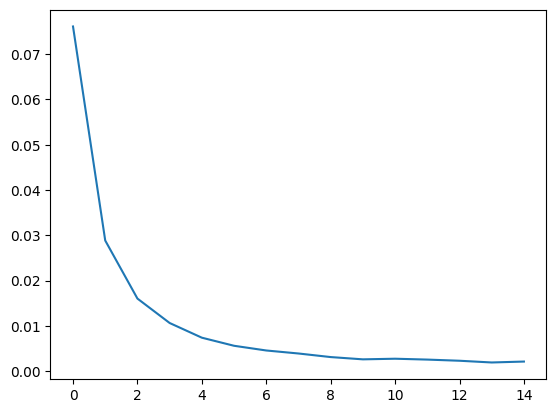

In [45]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

In [46]:
model.load_weights('../models/bad_words.model/01_checkpoint_0.14.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

485/485 [==============================] - 2s 4ms/step - loss: 0.1362 - accuracy: 0.9653
Accuracy of restored model 96.53%


In [47]:
model = tf.keras.models.load_model('../models/bad_words.model/01_checkpoint_0.14.hdf5')
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

485/485 [==============================] - 2s 4ms/step - loss: 0.1362 - accuracy: 0.9653
Accuracy of restored model 96.53%


In [48]:
!ls '../models/bad_words.model'

01_checkpoint_0.14.hdf5 01_checkpoint_0.17.hdf5 02_checkpoint_0.15.hdf5
01_checkpoint_0.16.hdf5 01_checkpoint_0.18.hdf5


In [49]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1938/1938 [==============================] - 8s 4ms/step


In [50]:
print(X_train[60:70])
print(y_train[60:70])
print(predictions[60:70])

['2212kendra-make look like fucked bound gagged'
 'rude roommates stinky feet pov part 2 princess yasmine hd1080p'
 'work socks' 'foot massage big feet hd'
 'pov crushing experience adidas cool climate sneakers'
 'diana knight pin pop balloon contest'
 'diana knight balloon pin pop contest'
 'diana knight balloons pin pop contest' '19jule2021_shorthj'
 'diana knight balloons pin pop games']
[0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [51]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [52]:
train.head()

,text_preprocessed,labels,predictions,text
0,favorite slut,0,0,My Favorite Slut
1,girlfriends sit faces asses,0,0,girlfriends sit on each other's faces with the...
2,bound beauty kisses girlfriend,0,0,bound beauty kisses her girlfriend
3,morgan anytime nail painting slave face,0,0,MORGAN - Anytime - Nail Painting On The Slave'...
4,transgender coaching wmv part 1,0,0,TRANSGENDER COACHING (wmv) PART 1


In [53]:
train.to_csv('../datasets/wo_html.csv')

In [54]:
model.save('../models/modelSequential_wo_HTML.h5')

In [55]:
#model_new = keras.models.load_model('../models/modelSequential.h5')
model_new = keras.models.load_model('../models/bad_words.model/01_checkpoint_0.14.hdf5')

In [56]:
predictions = model_new.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1938/1938 [==============================] - 8s 4ms/step


# Check sentence

In [85]:
raw_text = "bondage damsels distress rope ballgag ducttape"
test_text_preprocessed = bs(raw_text).get_text().replace('\n',' ')
test_text_preprocessed = preprocess(test_text_preprocessed, punctuation_marks, stop_words)
test_text_np = np.array([test_text_preprocessed])
test_sequences = tokenizer.texts_to_sequences(test_text_np)

In [86]:
print(test_text_preprocessed)
print(test_sequences[0])

bondage damsels distress rope ballgag ducttape
[10, 2645, 2385, 144, 1536, 9241]


In [87]:
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [88]:
%%time
predictions = model_new.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

1/1 [==============================] - 0s 45ms/step
CPU times: user 72.2 ms, sys: 9.71 ms, total: 81.9 ms
Wall time: 106 ms


In [89]:
predictions

[1]

In [62]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# max words in a sequence
max_length = 20

from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

def preprocess(text, stop_words, punctuation_marks): #, morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = token #morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)
    return ' '.join(preprocessed_text)

punctuation_marks = ['!', ',', ';', "'", '(', ')', ':', '-', '--', '', '?', '@', '....', '~',
                     '.', '..', '...', '<', '>', '=', '==', '\'\'', '//', '»', '|', '’', '`', '+',
                     '\"\"', '</', '&', '/', '#', '\'', '*', '``', '%', '[', ']', '{', '}', '$']


stop_words = stopwords.words('english') + ['14000kbps', 'https', "'s", "'m", 'http', 'mp4', 'error', '404']

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
model = keras.models.load_model('../models/modelSequential.h5')

raw_text = 'nigger'


def predict(sequences):
    sequences_padded = pad_sequences(sequences, maxlen=20, padding="post", truncating="post")
    predictions = model.predict(sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]
    return predictions

# Data loading and preparation
data = pd.read_json('../datasets/neil_ProducerClipSite_rand.json')
mapping = {False: 0, True: 1}
# data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['SiteID', 'Title', 'Description', 'Keywords', 'Bottom'], axis=1, inplace=True)
data.head()



[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Top
0,
1,
2,
3,
4,


In [63]:
data.Top

0                                                        
1                                                        
2                                                        
3                                                        
4                                                        
                              ...                        
9995                                                     
9996    <center><div class='top_html' align='center'><...
9997                                                     
9998                                                     
9999                                                     
Name: Top, Length: 10000, dtype: object

In [64]:
%%time
data['text_preprocessed'] = data.apply(lambda row: bs(row.Top, 'lxml').get_text().replace('\n',' '), axis=1)
data['text_preprocessed'] = data.apply(lambda row: preprocess(row.text_preprocessed, punctuation_marks, stop_words), axis=1)

X_val = data.text_preprocessed.to_numpy()
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

predictions = model.predict(X_val_padded)
predictions = [1 if p > .5 else 0 for p in predictions]


313/313 [==============================] - 2s 3ms/step
CPU times: user 7.65 s, sys: 312 ms, total: 7.96 s
Wall time: 6.96 s


In [65]:
data['predictions'] = predictions

In [66]:
data.head()

,Top,text_preprocessed,predictions
0,,,0
1,,,0
2,,,0
3,,,0
4,,,0


In [67]:
data = data[['Top', 'predictions']]

In [68]:
data.to_csv('../datasets/last_one.csv')

In [69]:
data.to_json('../datasets/last_one.json')